In [51]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.express as px

In [52]:
dataset_path = "C:/Users/zacha/OneDrive/Desktop/Neural Networks/FinalProject/animals"
labels_file = "C:/Users/zacha\OneDrive/Desktop/Neural Networks/FinalProject/name of the animals.txt"

In [53]:
# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [54]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

In [55]:
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

In [56]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [58]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers of EfficientNetB3
for layer in base_model.layers[-50:]:  # Fine-tune top layers
    layer.trainable = True

In [59]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [60]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(animal_names), activation='softmax')
])

In [61]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

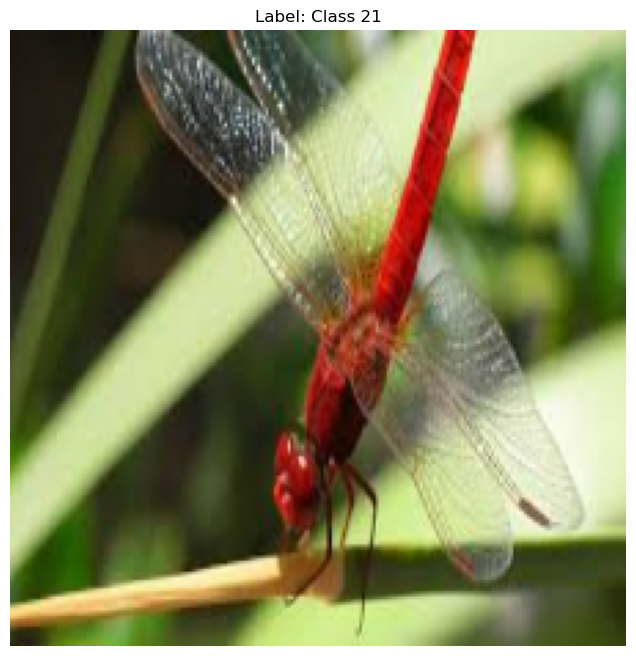

Image shape: (224, 224, 3)
Image type: float64
Min value: 0.0, Max value: 1.0
Class label: 21


In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random image from the training set
image_index = np.random.randint(0, len(X_train))
image = X_train[image_index]
label = y_train[image_index]

# Get the class names if available (replace with your actual class names)
# If you don't have class names, it will just show the numeric label
try:
    class_names = [...] # Replace with your class names if available
    class_label = class_names[label]
except:
    class_label = f"Class {label}"

# Normalize the image for visualization if needed
# If your images are already in the 0-255 range, you can skip this step
if image.max() <= 1.0:
    image_to_show = (image * 255).astype(np.uint8)
else:
    image_to_show = image.astype(np.uint8)

# Create the visualization
plt.figure(figsize=(8, 8))
plt.imshow(image_to_show)
plt.title(f"Label: {class_label}")
plt.axis('off')
plt.show()

# Print image details
print(f"Image shape: {image.shape}")
print(f"Image type: {image.dtype}")
print(f"Min value: {image.min()}, Max value: {image.max()}")
print(f"Class label: {label}")

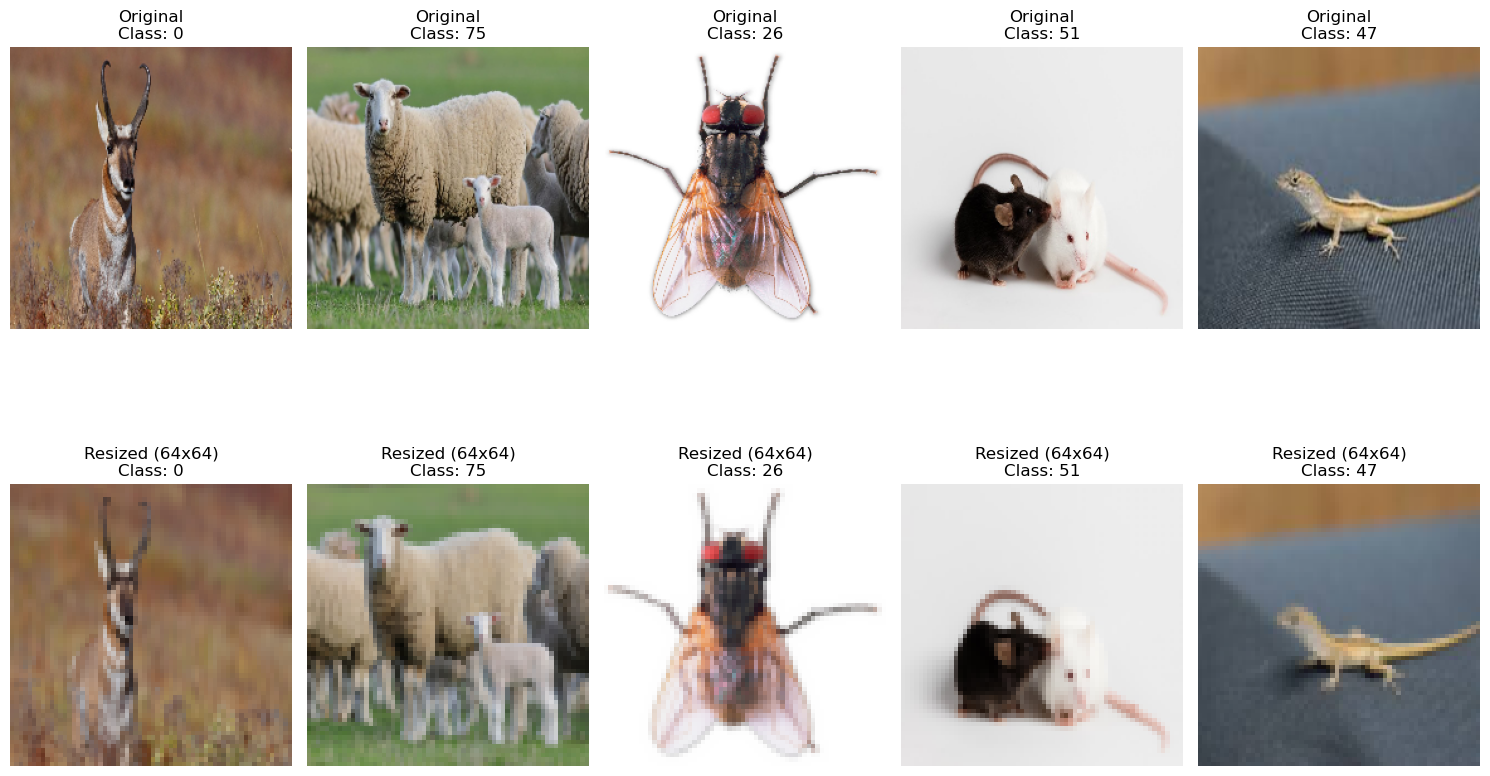

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Pick a few random images from the training set
num_images = 5
image_indices = np.random.randint(0, len(X_train), num_images)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(image_indices):
    # Get original image and label
    original_image = X_train[idx]
    label = y_train[idx]
    
    # Resize image to 64x64
    resized_image = resize(original_image, (64, 64, 3), preserve_range=True)
    
    # Display original image
    plt.subplot(2, num_images, i+1)
    
    # Prepare for visualization
    if original_image.max() <= 1.0:
        original_to_show = (original_image * 255).astype(np.uint8)
    else:
        original_to_show = original_image.astype(np.uint8)
        
    plt.imshow(original_to_show)
    plt.title(f"Original\nClass: {label}")
    plt.axis('off')
    
    # Display resized image
    plt.subplot(2, num_images, i+1+num_images)
    
    # Prepare resized for visualization
    if resized_image.max() <= 1.0:
        resized_to_show = (resized_image * 255).astype(np.uint8)
    else:
        resized_to_show = resized_image.astype(np.uint8)
        
    plt.imshow(resized_to_show)
    plt.title(f"Resized (64x64)\nClass: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [64]:
# Simple experiment with a pre-trained model
from sklearn.ensemble import RandomForestClassifier
from skimage.transform import resize
from sklearn.metrics import accuracy_score

# Resize images and flatten them
def prepare_for_rf(images, size=(32, 32)):
    resized = np.zeros((len(images), size[0], size[1], 3))
    for i, img in enumerate(images):
        resized[i] = resize(img, (size[0], size[1], 3), preserve_range=True)
    
    # Flatten the images
    return resized.reshape(len(images), -1)

# Prepare data - use very low resolution for speed
X_train_rf = prepare_for_rf(X_train, (16, 16))
X_test_rf = prepare_for_rf(X_test, (16, 16))

# Scale pixel values
X_train_rf = X_train_rf / 255.0
X_test_rf = X_test_rf / 255.0

# Train a Random Forest (non-deep learning approach)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train)

# Predict and check accuracy
y_pred = rf.predict(X_test_rf)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest accuracy: {accuracy:.4f}")

Random Forest accuracy: 0.3407


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
import time

# Clear previous models
tf.keras.backend.clear_session()
import gc
gc.collect()

# Use the working resize function
def resize_dataset(images, target_size=(64, 64)):
    resized = np.zeros((len(images), target_size[0], target_size[1], 3))
    for i, img in enumerate(images):
        resized[i] = resize(img, (target_size[0], target_size[1], 3), preserve_range=True)
    return resized

# Resize the data - use the exact same approach as your working code
print("Resizing training data...")
start_time = time.time()
X_train_resized = resize_dataset(X_train)
# Normalize properly using the same approach from your working code
if X_train_resized.max() > 1.0:
    X_train_resized = X_train_resized.astype('float32') / 255.0
print(f"Training data resized in {time.time() - start_time:.2f} seconds")

print("Resizing testing data...")
start_time = time.time()
X_test_resized = resize_dataset(X_test)
# Normalize properly
if X_test_resized.max() > 1.0:
    X_test_resized = X_test_resized.astype('float32') / 255.0
print(f"Testing data resized in {time.time() - start_time:.2f} seconds")

# Build a lightweight CNN from scratch
model = Sequential([
    # First block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Classification head
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Train the model
batch_size = 32
epochs = 150

print("Training model...")
start_time = time.time()

history = model.fit(
    datagen.flow(X_train_resized, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train_resized) // batch_size,
    epochs=epochs,
    validation_data=(X_test_resized, y_test),
    verbose=1
)

print(f"Model trained in {(time.time() - start_time) / 60:.2f} minutes")

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_resized, y_test, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Resizing training data...
Training data resized in 42.23 seconds
Resizing testing data...
Testing data resized in 13.60 seconds


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        11,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,129,178 (8.12 MB)

 Trainable params: 2,128,730 (8.12 MB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Epoch 1/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 182ms/step - accuracy: 0.0251 - loss: 4.9949 - val_accuracy: 0.0093 - val_loss: 9.5114
Epoch 2/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.0707 - loss: 4.3055 - val_accuracy: 0.0157 - val_loss: 17.9682
Epoch 3/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.0975 - loss: 3.9536 - val_accuracy: 0.0278 - val_loss: 10.5958
Epoch 4/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 217ms/step - accuracy: 0.1048 - loss: 3.8650 - val_accuracy: 0.0815 - val_loss: 6.8061
Epoch 5/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.1371 - loss: 3.7529 - val_accuracy: 0.1657 - val_loss: 3.5789
Epoch 6/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.1727 - loss: 3.4998 - val_accuracy: 0.1704 - val_loss: 3.5611
Epoch 7/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.1721 - loss: 3.4628 - val_accuracy: 0.1704 - val_loss: 3.5477
Epoch 8/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step 

In [ ]:
#save the model
keras.saving.save_model(model, 'my_model2.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True class: Animal 55

Top 3 predictions:
1. Animal 65: 45.73%
2. Animal 45: 17.60%
3. Animal 55: 16.65%


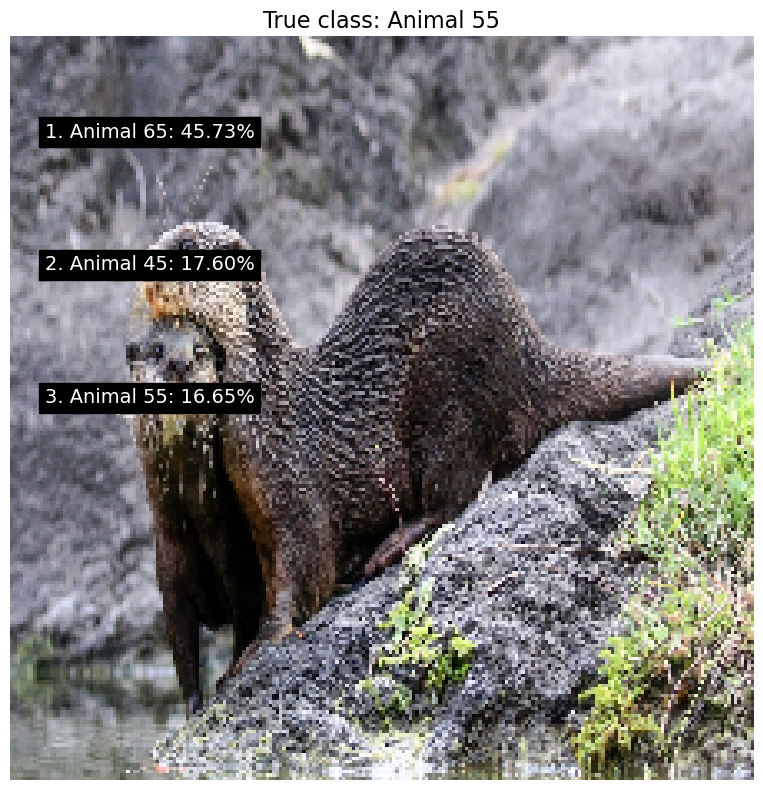

In [70]:
def predict_top_3_classes(model, image, target_size=(64, 64), class_names=None):
    """
    Predicts the top 3 classes for a given image using the trained model.
    
    Parameters:
    - model: Trained Keras model
    - image: Input image (numpy array)
    - target_size: Size to resize the image to match model input (height, width)
    - class_names: Dictionary mapping class indices to animal names
    
    Returns:
    - List of tuples containing (animal_name, probability)
    """
    import numpy as np
    from skimage.transform import resize
    
    # Resize the image using the working method
    resized_image = resize(image, (target_size[0], target_size[1], 3), preserve_range=True)
    
    # Normalize the image
    if resized_image.max() > 1.0:
        resized_image = resized_image.astype('float32') / 255.0
    
    # Add batch dimension
    input_image = np.expand_dims(resized_image, axis=0)
    
    # Get predictions
    predictions = model.predict(input_image)[0]
    
    # Get top 3 predictions
    top_indices = np.argsort(predictions)[-3:][::-1]
    top_probabilities = predictions[top_indices]
    
    # Create result list with animal names
    results = []
    for i, (idx, prob) in enumerate(zip(top_indices, top_probabilities)):
        if class_names and idx in class_names:
            animal_name = class_names[idx]
        else:
            animal_name = f"Animal {idx}"  # Fallback if name not available
            
        results.append((animal_name, prob))
    
    return results

# Example usage with animal names
# Create a dictionary that maps class indices to animal names (replace with your actual mapping)
animal_names = {
    0: "Dog",
    1: "Cat",
    2: "Bird",
    3: "Horse",
    4: "Elephant",
    # Add all your classes here
}

# Select a test image
test_idx = np.random.randint(0, len(X_test))
test_image = X_test[test_idx]
true_label = y_test[test_idx]
true_animal = animal_names.get(true_label, f"Animal {true_label}")

# Get predictions
predictions = predict_top_3_classes(model, test_image, class_names=animal_names)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
if test_image.max() <= 1.0:
    display_image = (test_image * 255).astype(np.uint8)
else:
    display_image = test_image.astype(np.uint8)
    
plt.imshow(display_image)
plt.title(f"True class: {true_animal}", fontsize=16)
plt.axis('off')

# Print and display predictions
print(f"True class: {true_animal}")
print("\nTop 3 predictions:")
for i, (animal, probability) in enumerate(predictions):
    confidence = probability * 100
    print(f"{i+1}. {animal}: {confidence:.2f}%")
    
    # Add text to the image
    plt.text(10, 30 + i*40, f"{i+1}. {animal}: {confidence:.2f}%", 
             fontsize=14, color='white', backgroundcolor='black')

plt.tight_layout()
plt.show()

In [67]:
def test_image_resizing(images, target_size=(64, 64), num_samples=5):
    """
    Tests the image resizing process and displays original vs resized images.
    
    Parameters:
    - images: Array of images to sample from
    - target_size: Target size as (height, width)
    - num_samples: Number of random images to sample and display
    
    Returns:
    - None (displays the images for visual inspection)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from skimage.transform import resize
    
    # Pick random images
    indices = np.random.randint(0, len(images), num_samples)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        # Get original image
        original_image = images[idx]
        
        # Resize image
        resized_image = resize(original_image, (target_size[0], target_size[1], 3), preserve_range=True)
        
        # Display original image
        plt.subplot(2, num_samples, i+1)
        
        # Prepare for visualization
        if original_image.max() <= 1.0:
            original_to_show = (original_image * 255).astype(np.uint8)
        else:
            original_to_show = original_image.astype(np.uint8)
            
        plt.imshow(original_to_show)
        plt.title(f"Original ({original_image.shape[0]}x{original_image.shape[1]})")
        plt.axis('off')
        
        # Display resized image
        plt.subplot(2, num_samples, i+1+num_samples)
        
        # Prepare resized for visualization
        if resized_image.max() <= 1.0:
            resized_to_show = (resized_image * 255).astype(np.uint8)
        else:
            resized_to_show = resized_image.astype(np.uint8)
            
        plt.imshow(resized_to_show)
        plt.title(f"Resized ({target_size[0]}x{target_size[1]})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print stats about a sample image before and after resizing
    sample_idx = indices[0]
    original = images[sample_idx]
    resized = resize(original, (target_size[0], target_size[1], 3), preserve_range=True)
    
    print(f"Original image: shape={original.shape}, dtype={original.dtype}, range={original.min()}-{original.max()}")
    print(f"Resized image: shape={resized.shape}, dtype={resized.dtype}, range={resized.min()}-{resized.max()}")
    
    # Check if the same code works for the entire dataset
    print("\nTesting batch resize on 100 images...")
    test_batch = images[:100]
    resized_batch = np.zeros((len(test_batch), target_size[0], target_size[1], 3))
    
    for i, img in enumerate(test_batch):
        resized_batch[i] = resize(img, (target_size[0], target_size[1], 3), preserve_range=True)
    
    print(f"Batch resize successful: shape={resized_batch.shape}, range={resized_batch.min()}-{resized_batch.max()}")
    return resized_batch  # Return a sample of resized images for further testing if needed



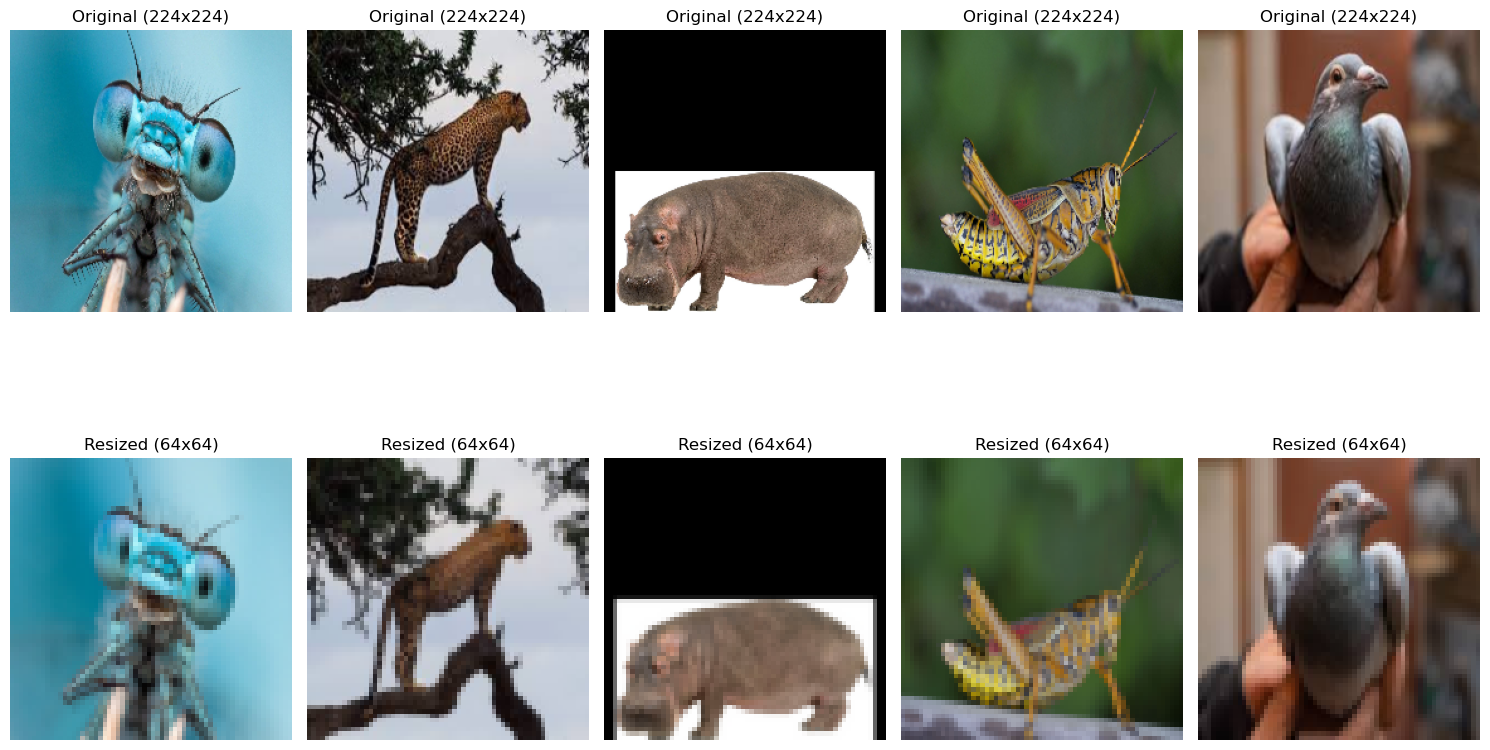

Original image: shape=(224, 224, 3), dtype=float64, range=0.0-1.0
Resized image: shape=(64, 64, 3), dtype=float64, range=0.0012764575772124995-0.9831237427194213

Testing batch resize on 100 images...
Batch resize successful: shape=(100, 64, 64, 3), range=0.0-1.0


In [68]:
# Example usage
resized_samples = test_image_resizing(X_train, target_size=(64, 64), num_samples=5)